In [358]:
%pip install scikit-learn -q
%pip install pandas -q
%pip install numpy -q
%pip install matplotlib -q
%pip install seaborn -q
%pip install keras -q
%pip install os -q

%pip install cvxopt -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import keras
from keras import layers
import tensorflow as tf
from sklearn import preprocessing, model_selection
import random
import seaborn as sns
import os
import cvxEDA

C:\Users\goert\AppData\Local\Temp\ipykernel_19512\2780907528.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:

MAIN_PATH = os.path.dirname(os.getcwd())
DATA_PATH = MAIN_PATH + "/data/"

QUALITY_THRESHOLD = 128
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = BATCH_SIZE * 2

In [3]:
dataset = pd.read_csv(DATA_PATH + "/merged_data.csv")

In [4]:
dataset.dtypes

w_eda                 float64
w_temp                float64
downsampled_labels    float64
ID                     object
Time                  float64
dtype: object

In [5]:
dataset

,w_eda,w_temp,downsampled_labels,ID,Time
0,1.138257,35.41,0.0,S2,0.00
1,1.125444,35.41,0.0,S2,0.25
2,1.011405,35.41,0.0,S2,0.50
3,1.033188,35.41,0.0,S2,0.75
4,0.935807,35.41,0.0,S2,1.00
...,...,...,...,...,...
347467,0.792287,31.81,0.0,S17,5918.75
347468,0.787170,31.81,0.0,S17,5919.00
347469,0.787170,31.81,0.0,S17,5919.25
347470,0.784611,31.81,0.0,S17,5919.50


In [6]:
import pandas as pd

# Function to create sequences DataFrame
def create_sequences_df(dataset, max_length=128):
    sequences = []
    temp_sequence = []
    eda_sequence = []
    label = None
    time_sequence = []
    current_id = None

    for index, row in dataset.iterrows():
        if current_id != row['ID']:
            # New ID encountered, append previous sequence to list
            if temp_sequence:
                sequences.append({
                    'ID': current_id,
                    'w_eda': eda_sequence,
                    'w_temp': temp_sequence,
                    'downsampled_label': label,
                    'Time': time_sequence
                })
            # Reset sequences for new ID
            temp_sequence = [row['w_temp']]
            eda_sequence = [row['w_eda']]
            label = row['downsampled_labels']
            time_sequence = [row['Time']]
            current_id = row['ID']
        else:
            # Append values to sequences
            temp_sequence.append(row['w_temp'])
            eda_sequence.append(row['w_eda'])
            time_sequence.append(row['Time'])

        # Check if sequence length exceeds max_length
        if len(temp_sequence) >= max_length:
            sequences.append({
                'ID': current_id,
                'w_eda': eda_sequence,
                'w_temp': temp_sequence,
                'downsampled_label': label,
                'Time': time_sequence
            })
            # Reset sequences for new ID
            temp_sequence = []
            eda_sequence = []
            label = None
            time_sequence = []
            current_id = None

    # Append last sequence if it's not empty
    if temp_sequence:
        sequences.append({
            'ID': current_id,
            'w_eda': eda_sequence,
            'w_temp': temp_sequence,
            'downsampled_label': label,
            'Time': time_sequence
        })

    # Convert list of dictionaries to DataFrame
    sequences_df = pd.DataFrame(sequences)
    return sequences_df

# Create sequences DataFrame
sequences_df = create_sequences_df(dataset)

# Check the resulting DataFrame
sequences_df

,ID,w_eda,w_temp,downsampled_label,Time
0,S2,"[1.138257, 1.125444, 1.011405, 1.033188, 0.935...","[35.41, 35.41, 35.41, 35.41, 35.41, 35.41, 35....",0.0,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2..."
1,S2,"[1.289355, 1.289355, 1.288074, 1.288074, 1.286...","[35.45, 35.45, 35.45, 35.45, 35.45, 35.45, 35....",0.0,"[32.0, 32.25, 32.5, 32.75, 33.0, 33.25, 33.5, ..."
2,S2,"[0.962616, 0.958772, 0.94724, 0.943396, 0.9369...","[35.57, 35.57, 35.57, 35.57, 35.55, 35.55, 35....",0.0,"[64.0, 64.25, 64.5, 64.75, 65.0, 65.25, 65.5, ..."
3,S2,"[1.135595, 1.131751, 1.131751, 1.129189, 1.126...","[35.49, 35.49, 35.49, 35.49, 35.49, 35.49, 35....",0.0,"[96.0, 96.25, 96.5, 96.75, 97.0, 97.25, 97.5, ..."
4,S2,"[1.011306, 1.008744, 1.007462, 1.006181, 1.006...","[35.57, 35.57, 35.57, 35.57, 35.57, 35.57, 35....",0.0,"[128.0, 128.25, 128.5, 128.75, 129.0, 129.25, ..."
...,...,...,...,...,...
2715,S17,"[1.012345, 1.005948, 1.004668, 1.00083, 0.9995...","[31.87, 31.87, 31.87, 31.87, 31.87, 31.87, 31....",0.0,"[5760.0, 5760.25, 5760.5, 5760.75, 5761.0, 576..."
2716,S17,"[1.003389, 0.995713, 0.996992, 0.993154, 0.995...","[31.91, 31.91, 31.91, 31.91, 31.91, 31.91, 31....",0.0,"[5792.0, 5792.25, 5792.5, 5792.75, 5793.0, 579..."
2717,S17,"[0.981639, 0.976522, 0.97908, 0.97908, 0.98036...","[31.97, 31.93, 31.93, 31.93, 31.93, 31.93, 31....",0.0,"[5824.0, 5824.25, 5824.5, 5824.75, 5825.0, 582..."
2718,S17,"[0.963728, 0.95861, 0.965007, 0.976522, 0.9765...","[31.93, 31.95, 31.95, 31.95, 31.95, 31.93, 31....",0.0,"[5856.0, 5856.25, 5856.5, 5856.75, 5857.0, 585..."


In [7]:
print(sequences_df.loc[88, 'w_eda'])


[1.068966, 1.07281, 1.076654, 1.074091, 1.07281, 1.074091, 1.077935, 1.080498, 1.080498, 1.080498, 1.085623, 1.09203, 1.108687, 1.13047, 1.14969, 1.165066, 1.174035, 1.181723, 1.184286, 1.181723, 1.175317, 1.16891, 1.165066, 1.158659, 1.152253, 1.144565, 1.134314, 1.125345, 1.120219, 1.121501, 1.126626, 1.133033, 1.138158, 1.144565, 1.148409, 1.153534, 1.162503, 1.162503, 1.161222, 1.161222, 1.157378, 1.154815, 1.154815, 1.150971, 1.147127, 1.145846, 1.144565, 1.143283, 1.140721, 1.131751, 1.127907, 1.127907, 1.133033, 1.131751, 1.135595, 1.135595, 1.135595, 1.139439, 1.140721, 1.142002, 1.142002, 1.138158, 1.138158, 1.135595, 1.134314, 1.133033, 1.13047, 1.13047, 1.127907, 1.125345, 1.124063, 1.122782, 1.121501, 1.120219, 1.120219, 1.118938, 1.118938, 1.109969, 1.104843, 1.100999, 1.102281, 1.112531, 1.122782, 1.122782, 1.134314, 1.148409, 1.159941, 1.167629, 1.159941, 1.156097, 1.154815, 1.154815, 1.153534, 1.153534, 1.150971, 1.147127, 1.144565, 1.139439, 1.136877, 1.131751, 1.12790

In [8]:
print(sequences_df)

       ID                                              w_eda  \
0      S2  [1.138257, 1.125444, 1.011405, 1.033188, 0.935...   
1      S2  [1.289355, 1.289355, 1.288074, 1.288074, 1.286...   
2      S2  [0.962616, 0.958772, 0.94724, 0.943396, 0.9369...   
3      S2  [1.135595, 1.131751, 1.131751, 1.129189, 1.126...   
4      S2  [1.011306, 1.008744, 1.007462, 1.006181, 1.006...   
...   ...                                                ...   
2715  S17  [1.012345, 1.005948, 1.004668, 1.00083, 0.9995...   
2716  S17  [1.003389, 0.995713, 0.996992, 0.993154, 0.995...   
2717  S17  [0.981639, 0.976522, 0.97908, 0.97908, 0.98036...   
2718  S17  [0.963728, 0.95861, 0.965007, 0.976522, 0.9765...   
2719  S17  [0.931742, 0.929184, 0.933022, 0.929184, 0.931...   

                                                 w_temp  downsampled_label  \
0     [35.41, 35.41, 35.41, 35.41, 35.41, 35.41, 35....                0.0   
1     [35.45, 35.45, 35.45, 35.45, 35.45, 35.45, 35....                0.0 

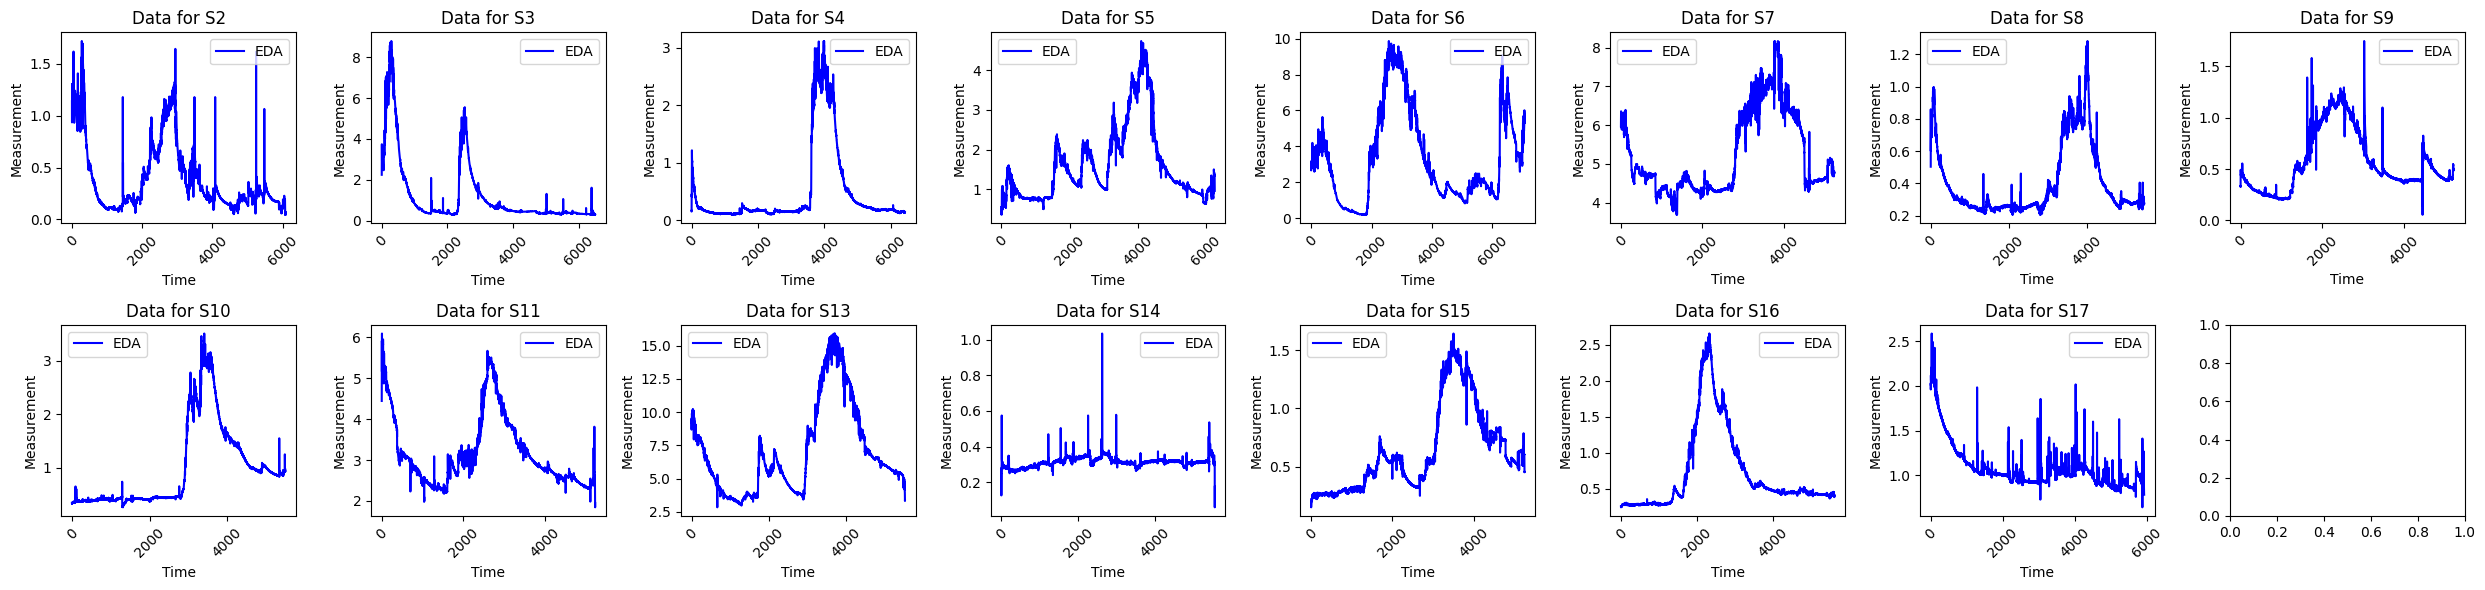

In [367]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, axes = plt.subplots(2, 8, figsize=(25, 6))  # Increased figure size
axes = axes.flatten()

# Define unique_ids
unique_ids = dataset['ID'].unique()

# Iterate through each unique id
for i, unique_id in enumerate(unique_ids):
    if i < len(unique_ids):
        # Filter data for each id
        subset_data = dataset[dataset['ID'] == unique_id]
        
        # Plotting
        sns.lineplot(x='Time', y='w_eda', data=subset_data, ax=axes[i], color='blue', label='EDA')
        # sns.lineplot(x='Time', y='w_temp', data=subset_data, ax=axes[i], color='red', label='Temp')

        axes[i].set_title(f"Data for {unique_id}")
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('Measurement')
        axes[i].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


In [368]:
# import matplotlib.pyplot as plt

# # Create subplots
# fig, axes = plt.subplots(16, 3, figsize=(60, 40))  # Increased figure size

# # Define colors for each acceleration component
# colors = ['red', 'green', 'blue']

# # Iterate through each unique id
# for i, unique_id in enumerate(unique_ids):
#     # Filter data for each id
#     subset_data = dataset[dataset['ID'] == unique_id]
    
#     # Iterate through X, Y, and Z accelerations
#     for j, accel_component in enumerate(['X', 'Y', 'Z']):
#         ax = axes[i, j]  # Select the appropriate subplot
        
#         # Plot acceleration component with different color
#         ax.plot(subset_data['Time'], subset_data[accel_component], label=f'{accel_component} Acceleration', color=colors[j])
#         ax.set_title(f"Data for {unique_id} - {accel_component} Acceleration")
#         ax.set_xlabel('Time')
#         ax.set_ylabel('Acceleration')
#         ax.legend()
#         ax.tick_params(axis='x', rotation=45)

# # Adjust layout
# plt.tight_layout()
# plt.show()


In [369]:
import cvxEDA.src.cvxEDA

def calculate_eda_levels(y):
    fs_dict = {'ACC': 32, 'BVP': 64, 'EDA': 4, 'TEMP': 4, 'label': 700, 'Resp': 700}
    Fs = fs_dict['EDA']
    yn = (y - y.mean()) / y.std()
    [r, p, t, l, d, e, obj] = cvxEDA.src.cvxEDA.cvxEDA(yn, 1. / Fs)
    return [p, t]


     pcost       dcost       gap    pres   dres
 0: -1.2092e+04 -1.2037e+04  5e+04  2e+02  2e-01
 1: -1.2089e+04 -2.0310e+04  1e+04  4e+01  5e-02
 2: -1.2096e+04 -1.5177e+04  3e+03  1e+01  1e-02
 3: -1.2097e+04 -1.3431e+04  1e+03  4e+00  4e-03
 4: -1.2096e+04 -1.2680e+04  6e+02  1e+00  2e-03
 5: -1.2091e+04 -1.2408e+04  3e+02  5e-01  6e-04
 6: -1.2091e+04 -1.2262e+04  2e+02  2e-01  3e-04
 7: -1.2109e+04 -1.2156e+04  5e+01  3e-02  4e-05
 8: -1.2129e+04 -1.2144e+04  1e+01  9e-03  1e-05
 9: -1.2136e+04 -1.2142e+04  6e+00  3e-03  3e-06
10: -1.2139e+04 -1.2142e+04  3e+00  8e-04  1e-06
11: -1.2140e+04 -1.2141e+04  1e+00  2e-04  2e-07
12: -1.2141e+04 -1.2141e+04  4e-01  4e-05  5e-08
13: -1.2141e+04 -1.2141e+04  1e-01  8e-06  1e-08
14: -1.2141e+04 -1.2141e+04  3e-02  5e-07  6e-10
15: -1.2141e+04 -1.2141e+04  9e-03  5e-08  7e-11
16: -1.2141e+04 -1.2141e+04  3e-03  1e-08  1e-11
17: -1.2141e+04 -1.2141e+04  7e-04  2e-09  2e-12
18: -1.2141e+04 -1.2141e+04  1e-04  2e-10  2e-13
19: -1.2141e+04 -1.21

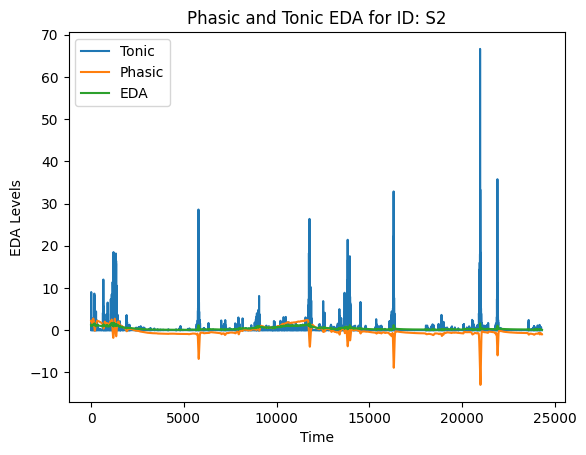

     pcost       dcost       gap    pres   dres
 0: -1.2965e+04 -1.2924e+04  5e+04  2e+02  1e-01
 1: -1.2950e+04 -1.7515e+04  5e+03  2e+01  2e-02
 2: -1.2952e+04 -1.3636e+04  7e+02  3e+00  2e-03
 3: -1.2950e+04 -1.3146e+04  2e+02  7e-01  4e-04
 4: -1.2956e+04 -1.3006e+04  5e+01  1e-01  7e-05
 5: -1.2973e+04 -1.2984e+04  1e+01  1e-02  8e-06
 6: -1.2978e+04 -1.2983e+04  5e+00  3e-03  2e-06
 7: -1.2981e+04 -1.2983e+04  2e+00  1e-03  7e-07
 8: -1.2982e+04 -1.2983e+04  8e-01  3e-04  2e-07
 9: -1.2983e+04 -1.2983e+04  3e-01  7e-05  5e-08
10: -1.2983e+04 -1.2983e+04  1e-01  2e-05  1e-08
11: -1.2983e+04 -1.2983e+04  4e-02  4e-06  3e-09
12: -1.2983e+04 -1.2983e+04  1e-02  7e-07  5e-10
13: -1.2983e+04 -1.2983e+04  3e-03  1e-07  9e-11
14: -1.2983e+04 -1.2983e+04  9e-04  2e-08  1e-11
15: -1.2983e+04 -1.2983e+04  3e-04  3e-09  2e-12
16: -1.2983e+04 -1.2983e+04  6e-05  2e-10  2e-13
17: -1.2983e+04 -1.2983e+04  1e-05  2e-11  2e-14
18: -1.2983e+04 -1.2983e+04  2e-06  2e-12  8e-15
Optimal solution foun

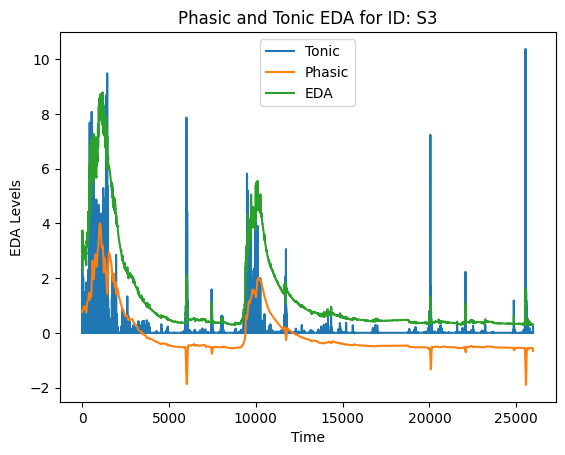

     pcost       dcost       gap    pres   dres
 0: -1.2831e+04 -1.2794e+04  4e+04  2e+02  3e-01
 1: -1.2816e+04 -1.6678e+04  4e+03  2e+01  3e-02
 2: -1.2818e+04 -1.3589e+04  8e+02  4e+00  5e-03
 3: -1.2817e+04 -1.2947e+04  1e+02  5e-01  7e-04
 4: -1.2826e+04 -1.2848e+04  2e+01  2e-02  3e-05
 5: -1.2840e+04 -1.2844e+04  5e+00  5e-03  7e-06
 6: -1.2842e+04 -1.2844e+04  2e+00  2e-03  3e-06
 7: -1.2843e+04 -1.2844e+04  9e-01  6e-04  9e-07
 8: -1.2844e+04 -1.2844e+04  4e-01  6e-05  9e-08
 9: -1.2844e+04 -1.2844e+04  9e-02  1e-05  2e-08
10: -1.2844e+04 -1.2844e+04  3e-02  2e-06  3e-09
11: -1.2844e+04 -1.2844e+04  8e-03  4e-07  6e-10
12: -1.2844e+04 -1.2844e+04  3e-03  7e-08  1e-10
13: -1.2844e+04 -1.2844e+04  7e-04  6e-09  9e-12
14: -1.2844e+04 -1.2844e+04  2e-04  6e-10  1e-12
15: -1.2844e+04 -1.2844e+04  4e-05  7e-11  1e-13
16: -1.2844e+04 -1.2844e+04  7e-06  8e-12  2e-14
Optimal solution found.


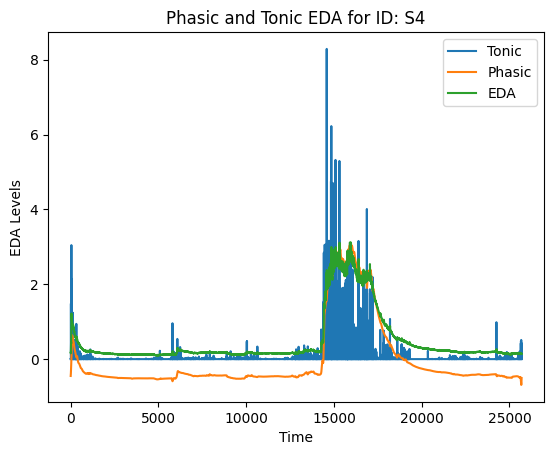

     pcost       dcost       gap    pres   dres
 0: -1.2498e+04 -1.2465e+04  4e+04  2e+02  3e-01
 1: -1.2481e+04 -1.6433e+04  4e+03  2e+01  3e-02
 2: -1.2479e+04 -1.3513e+04  1e+03  5e+00  6e-03
 3: -1.2476e+04 -1.2812e+04  3e+02  1e+00  1e-03
 4: -1.2473e+04 -1.2622e+04  1e+02  4e-01  5e-04
 5: -1.2483e+04 -1.2529e+04  5e+01  8e-02  9e-05
 6: -1.2498e+04 -1.2515e+04  2e+01  3e-02  3e-05
 7: -1.2505e+04 -1.2512e+04  7e+00  4e-03  5e-06
 8: -1.2509e+04 -1.2512e+04  3e+00  8e-04  1e-06
 9: -1.2510e+04 -1.2511e+04  1e+00  2e-04  3e-07
10: -1.2511e+04 -1.2511e+04  3e-01  4e-05  5e-08
11: -1.2511e+04 -1.2511e+04  1e-01  1e-05  2e-08
12: -1.2511e+04 -1.2511e+04  4e-02  2e-06  3e-09
13: -1.2511e+04 -1.2511e+04  1e-02  2e-07  2e-10
14: -1.2511e+04 -1.2511e+04  3e-03  1e-08  1e-11
15: -1.2511e+04 -1.2511e+04  1e-03  2e-09  2e-12
16: -1.2511e+04 -1.2511e+04  3e-04  3e-10  3e-13
17: -1.2511e+04 -1.2511e+04  8e-05  6e-11  7e-14
18: -1.2511e+04 -1.2511e+04  1e-05  4e-12  1e-14
Optimal solution foun

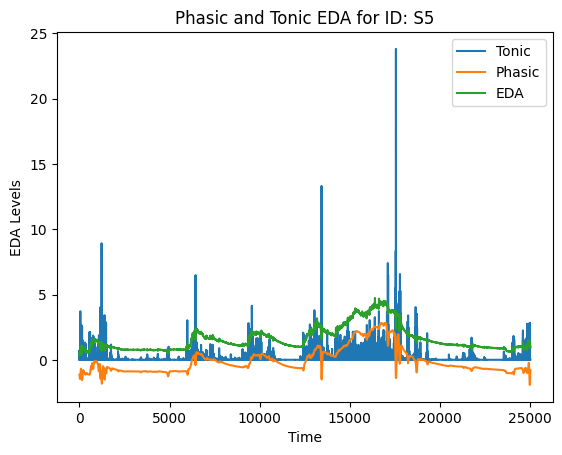

     pcost       dcost       gap    pres   dres
 0: -1.4123e+04 -1.4083e+04  4e+04  2e+02  4e-01
 1: -1.4106e+04 -1.7005e+04  3e+03  1e+01  3e-02
 2: -1.4110e+04 -1.4625e+04  5e+02  2e+00  4e-03
 3: -1.4110e+04 -1.4255e+04  1e+02  5e-01  1e-03
 4: -1.4112e+04 -1.4158e+04  5e+01  9e-02  2e-04
 5: -1.4128e+04 -1.4140e+04  1e+01  2e-02  4e-05
 6: -1.4134e+04 -1.4139e+04  5e+00  5e-03  1e-05
 7: -1.4136e+04 -1.4138e+04  2e+00  1e-03  2e-06
 8: -1.4137e+04 -1.4138e+04  7e-01  3e-04  6e-07
 9: -1.4137e+04 -1.4138e+04  2e-01  6e-05  1e-07
10: -1.4138e+04 -1.4138e+04  6e-02  1e-05  3e-08
11: -1.4138e+04 -1.4138e+04  2e-02  3e-06  5e-09
12: -1.4138e+04 -1.4138e+04  6e-03  4e-07  7e-10
13: -1.4138e+04 -1.4138e+04  2e-03  7e-08  1e-10
14: -1.4138e+04 -1.4138e+04  4e-04  6e-09  1e-11
15: -1.4138e+04 -1.4138e+04  1e-04  6e-10  1e-12
16: -1.4138e+04 -1.4138e+04  3e-05  7e-11  1e-13
17: -1.4138e+04 -1.4138e+04  4e-06  6e-12  1e-14
Optimal solution found.


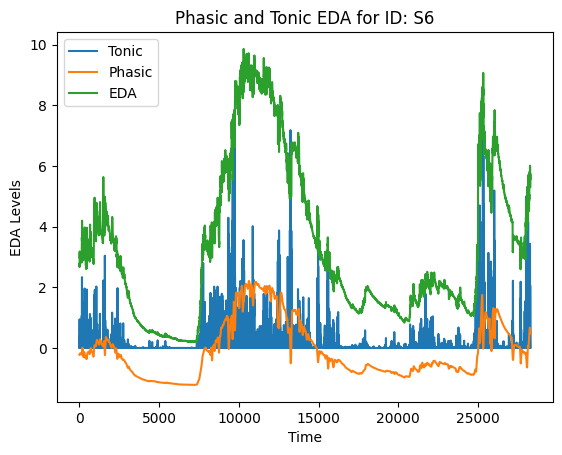

     pcost       dcost       gap    pres   dres
 0: -1.0444e+04 -1.0412e+04  3e+04  2e+02  2e-01
 1: -1.0435e+04 -1.3716e+04  4e+03  2e+01  2e-02
 2: -1.0437e+04 -1.1602e+04  1e+03  5e+00  6e-03
 3: -1.0436e+04 -1.0851e+04  4e+02  1e+00  2e-03
 4: -1.0436e+04 -1.0595e+04  2e+02  4e-01  5e-04
 5: -1.0440e+04 -1.0498e+04  6e+01  1e-01  1e-04
 6: -1.0457e+04 -1.0470e+04  1e+01  1e-02  2e-05
 7: -1.0462e+04 -1.0469e+04  6e+00  5e-03  6e-06
 8: -1.0465e+04 -1.0468e+04  3e+00  1e-03  1e-06
 9: -1.0466e+04 -1.0468e+04  1e+00  4e-04  5e-07
10: -1.0467e+04 -1.0468e+04  5e-01  9e-05  1e-07
11: -1.0467e+04 -1.0467e+04  2e-01  2e-05  2e-08
12: -1.0467e+04 -1.0467e+04  4e-02  3e-06  4e-09
13: -1.0467e+04 -1.0467e+04  1e-02  6e-07  7e-10
14: -1.0467e+04 -1.0467e+04  4e-03  1e-07  1e-10
15: -1.0467e+04 -1.0467e+04  1e-03  1e-08  2e-11
16: -1.0467e+04 -1.0467e+04  3e-04  2e-09  2e-12
17: -1.0467e+04 -1.0467e+04  5e-05  2e-10  3e-13
18: -1.0467e+04 -1.0467e+04  6e-06  1e-11  2e-14
Optimal solution foun

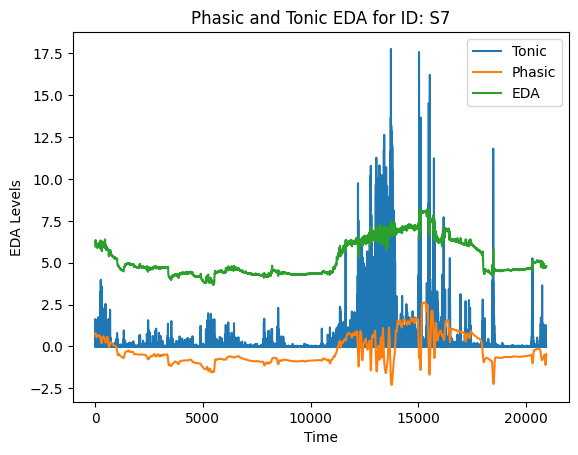

     pcost       dcost       gap    pres   dres
 0: -1.0913e+04 -1.0883e+04  3e+04  2e+02  3e-01
 1: -1.0902e+04 -1.4280e+04  4e+03  2e+01  4e-02
 2: -1.0901e+04 -1.1712e+04  8e+02  4e+00  7e-03
 3: -1.0898e+04 -1.1154e+04  3e+02  9e-01  2e-03
 4: -1.0900e+04 -1.0981e+04  8e+01  2e-01  4e-04
 5: -1.0911e+04 -1.0929e+04  2e+01  9e-03  2e-05
 6: -1.0920e+04 -1.0927e+04  8e+00  3e-03  6e-06
 7: -1.0923e+04 -1.0927e+04  4e+00  1e-03  2e-06
 8: -1.0925e+04 -1.0927e+04  1e+00  2e-04  4e-07
 9: -1.0926e+04 -1.0927e+04  4e-01  4e-05  8e-08
10: -1.0926e+04 -1.0926e+04  2e-01  1e-05  2e-08
11: -1.0926e+04 -1.0926e+04  5e-02  2e-06  4e-09
12: -1.0926e+04 -1.0926e+04  1e-02  4e-07  7e-10
13: -1.0926e+04 -1.0926e+04  4e-03  6e-08  1e-10
14: -1.0926e+04 -1.0926e+04  9e-04  9e-09  2e-11
15: -1.0926e+04 -1.0926e+04  2e-04  5e-10  1e-12
16: -1.0926e+04 -1.0926e+04  3e-05  7e-11  1e-13
17: -1.0926e+04 -1.0926e+04  2e-06  5e-12  1e-14
Optimal solution found.


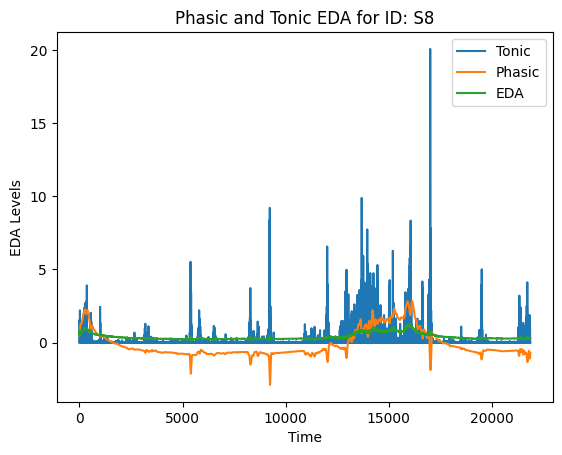

     pcost       dcost       gap    pres   dres
 0: -1.0396e+04 -1.0351e+04  5e+04  2e+02  5e-01
 1: -1.0392e+04 -1.8135e+04  1e+04  4e+01  1e-01
 2: -1.0396e+04 -1.3139e+04  3e+03  9e+00  2e-02
 3: -1.0396e+04 -1.1846e+04  1e+03  4e+00  1e-02
 4: -1.0391e+04 -1.1247e+04  9e+02  2e+00  4e-03
 5: -1.0387e+04 -1.0842e+04  5e+02  8e-01  2e-03
 6: -1.0390e+04 -1.0545e+04  2e+02  2e-01  5e-04
 7: -1.0404e+04 -1.0454e+04  5e+01  5e-02  1e-04
 8: -1.0423e+04 -1.0438e+04  2e+01  1e-02  3e-05
 9: -1.0429e+04 -1.0436e+04  7e+00  4e-03  1e-05
10: -1.0433e+04 -1.0435e+04  3e+00  9e-04  2e-06
11: -1.0434e+04 -1.0435e+04  1e+00  2e-04  6e-07
12: -1.0434e+04 -1.0435e+04  4e-01  5e-05  1e-07
13: -1.0435e+04 -1.0435e+04  1e-01  1e-05  4e-08
14: -1.0435e+04 -1.0435e+04  5e-02  4e-06  1e-08
15: -1.0435e+04 -1.0435e+04  1e-02  6e-07  2e-09
16: -1.0435e+04 -1.0435e+04  4e-03  1e-07  3e-10
17: -1.0435e+04 -1.0435e+04  1e-03  2e-08  5e-11
18: -1.0435e+04 -1.0435e+04  3e-04  4e-09  1e-11
19: -1.0435e+04 -1.04

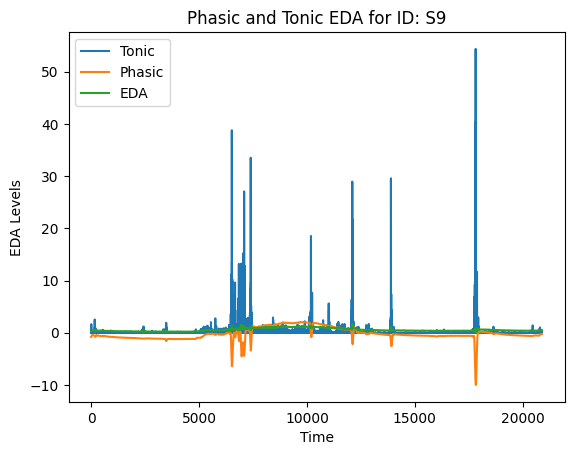

     pcost       dcost       gap    pres   dres
 0: -1.0985e+04 -1.0958e+04  3e+04  2e+02  2e-01
 1: -1.0969e+04 -1.4088e+04  3e+03  2e+01  2e-02
 2: -1.0968e+04 -1.1548e+04  6e+02  3e+00  3e-03
 3: -1.0965e+04 -1.1147e+04  2e+02  7e-01  7e-04
 4: -1.0965e+04 -1.1024e+04  6e+01  1e-01  1e-04
 5: -1.0979e+04 -1.0993e+04  1e+01  2e-02  2e-05
 6: -1.0985e+04 -1.0991e+04  6e+00  8e-03  8e-06
 7: -1.0987e+04 -1.0990e+04  3e+00  7e-04  7e-07
 8: -1.0989e+04 -1.0990e+04  1e+00  7e-05  7e-08
 9: -1.0990e+04 -1.0990e+04  3e-01  2e-05  2e-08
10: -1.0990e+04 -1.0990e+04  1e-01  7e-06  6e-09
11: -1.0990e+04 -1.0990e+04  5e-02  2e-06  1e-09
12: -1.0990e+04 -1.0990e+04  1e-02  3e-07  3e-10
13: -1.0990e+04 -1.0990e+04  4e-03  6e-08  6e-11
14: -1.0990e+04 -1.0990e+04  1e-03  1e-08  1e-11
15: -1.0990e+04 -1.0990e+04  3e-04  1e-09  1e-12
16: -1.0990e+04 -1.0990e+04  8e-05  1e-10  1e-13
17: -1.0990e+04 -1.0990e+04  2e-05  2e-11  2e-14
18: -1.0990e+04 -1.0990e+04  3e-06  2e-12  1e-14
Optimal solution foun

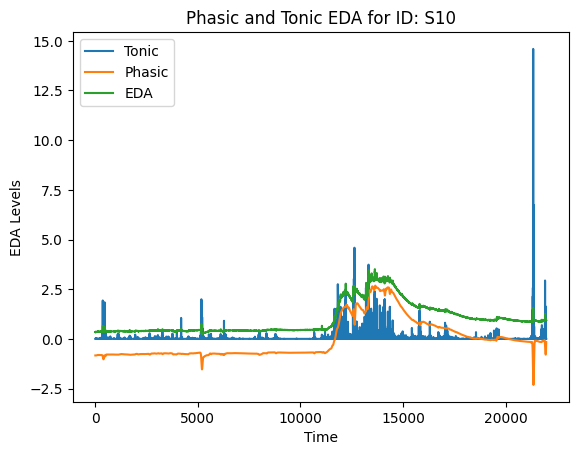

     pcost       dcost       gap    pres   dres
 0: -1.0441e+04 -1.0412e+04  3e+04  2e+02  3e-01
 1: -1.0432e+04 -1.4107e+04  4e+03  2e+01  3e-02
 2: -1.0433e+04 -1.1471e+04  1e+03  5e+00  7e-03
 3: -1.0429e+04 -1.0832e+04  4e+02  1e+00  2e-03
 4: -1.0431e+04 -1.0528e+04  1e+02  2e-01  4e-04
 5: -1.0441e+04 -1.0464e+04  2e+01  1e-02  2e-05
 6: -1.0452e+04 -1.0462e+04  1e+01  5e-03  8e-06
 7: -1.0457e+04 -1.0461e+04  4e+00  2e-03  2e-06
 8: -1.0459e+04 -1.0460e+04  2e+00  4e-04  5e-07
 9: -1.0460e+04 -1.0460e+04  7e-01  1e-04  2e-07
10: -1.0460e+04 -1.0460e+04  2e-01  3e-05  4e-08
11: -1.0460e+04 -1.0460e+04  7e-02  5e-06  7e-09
12: -1.0460e+04 -1.0460e+04  2e-02  8e-07  1e-09
13: -1.0460e+04 -1.0460e+04  7e-03  2e-07  3e-10
14: -1.0460e+04 -1.0460e+04  2e-03  3e-08  4e-11
15: -1.0460e+04 -1.0460e+04  6e-04  4e-09  6e-12
16: -1.0460e+04 -1.0460e+04  1e-04  5e-10  8e-13
17: -1.0460e+04 -1.0460e+04  2e-05  5e-11  7e-14
18: -1.0460e+04 -1.0460e+04  4e-06  5e-12  1e-14
Optimal solution foun

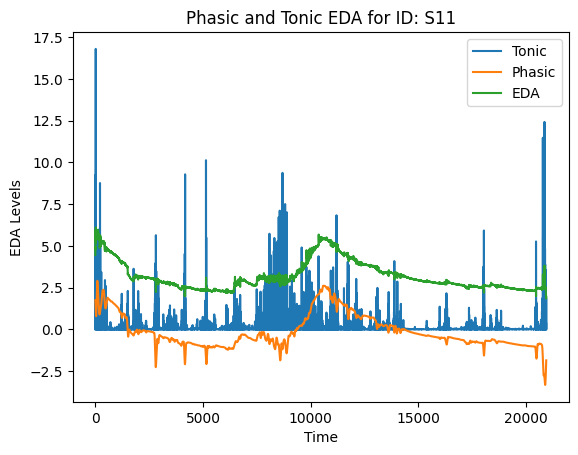

     pcost       dcost       gap    pres   dres
 0: -1.1062e+04 -1.1037e+04  3e+04  2e+02  2e-01
 1: -1.1047e+04 -1.3040e+04  2e+03  1e+01  2e-02
 2: -1.1049e+04 -1.1535e+04  5e+02  3e+00  3e-03
 3: -1.1046e+04 -1.1220e+04  2e+02  7e-01  8e-04
 4: -1.1050e+04 -1.1092e+04  4e+01  1e-01  1e-04
 5: -1.1060e+04 -1.1074e+04  1e+01  3e-02  4e-05
 6: -1.1066e+04 -1.1071e+04  5e+00  8e-03  1e-05
 7: -1.1069e+04 -1.1071e+04  2e+00  2e-03  3e-06
 8: -1.1070e+04 -1.1071e+04  7e-01  6e-04  7e-07
 9: -1.1070e+04 -1.1071e+04  3e-01  2e-04  2e-07
10: -1.1070e+04 -1.1070e+04  9e-02  2e-05  3e-08
11: -1.1070e+04 -1.1070e+04  3e-02  6e-06  7e-09
12: -1.1070e+04 -1.1070e+04  8e-03  8e-07  1e-09
13: -1.1070e+04 -1.1070e+04  2e-03  1e-07  1e-10
14: -1.1070e+04 -1.1070e+04  6e-04  6e-09  7e-12
15: -1.1070e+04 -1.1070e+04  1e-04  3e-10  4e-13
16: -1.1070e+04 -1.1070e+04  3e-05  1e-11  2e-14
17: -1.1070e+04 -1.1070e+04  7e-06  2e-12  7e-15
Optimal solution found.


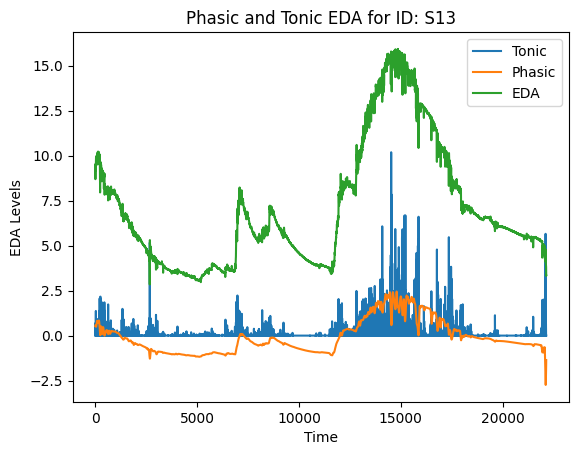

     pcost       dcost       gap    pres   dres
 0: -9.9520e+03 -9.5586e+03  3e+05  4e+02  1e+00
 1: -1.0251e+04 -8.2961e+04  9e+04  9e+01  2e-01
 2: -1.0424e+04 -5.3757e+04  5e+04  4e+01  9e-02
 3: -1.0467e+04 -5.1286e+04  4e+04  3e+01  8e-02
 4: -1.0561e+04 -3.4237e+04  2e+04  2e+01  4e-02
 5: -1.0608e+04 -3.1041e+04  2e+04  1e+01  3e-02
 6: -1.0664e+04 -2.2132e+04  1e+04  6e+00  1e-02
 7: -1.0688e+04 -1.7868e+04  7e+03  3e+00  6e-03
 8: -1.0684e+04 -1.4269e+04  4e+03  1e+00  2e-03
 9: -1.0688e+04 -1.2493e+04  2e+03  5e-01  1e-03
10: -1.0655e+04 -1.1680e+04  1e+03  2e-01  4e-04
11: -1.0716e+04 -1.0987e+04  3e+02  3e-02  7e-05
12: -1.0762e+04 -1.0886e+04  1e+02  4e-03  8e-06
13: -1.0798e+04 -1.0873e+04  8e+01  2e-03  4e-06
14: -1.0815e+04 -1.0866e+04  5e+01  3e-04  6e-07
15: -1.0840e+04 -1.0861e+04  2e+01  6e-05  1e-07
16: -1.0849e+04 -1.0859e+04  1e+01  1e-05  3e-08
17: -1.0853e+04 -1.0857e+04  5e+00  5e-06  1e-08
18: -1.0855e+04 -1.0857e+04  2e+00  1e-06  3e-09
19: -1.0856e+04 -1.08

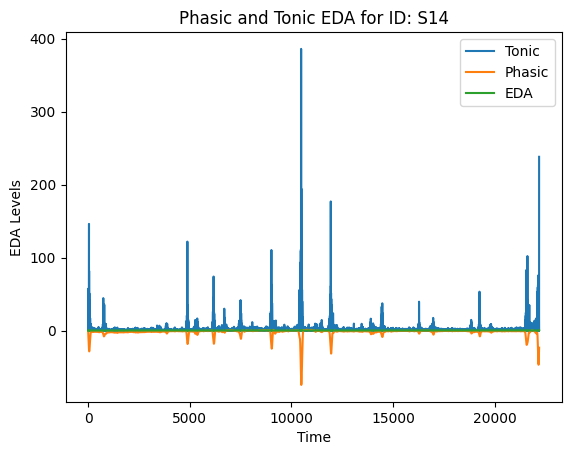

     pcost       dcost       gap    pres   dres
 0: -1.0492e+04 -1.0467e+04  3e+04  2e+02  1e-01
 1: -1.0479e+04 -1.2422e+04  2e+03  1e+01  1e-02
 2: -1.0478e+04 -1.0990e+04  5e+02  3e+00  2e-03
 3: -1.0476e+04 -1.0707e+04  2e+02  1e+00  8e-04
 4: -1.0473e+04 -1.0564e+04  9e+01  3e-01  2e-04
 5: -1.0485e+04 -1.0503e+04  2e+01  1e-02  1e-05
 6: -1.0493e+04 -1.0501e+04  8e+00  4e-03  3e-06
 7: -1.0497e+04 -1.0501e+04  3e+00  1e-03  1e-06
 8: -1.0499e+04 -1.0501e+04  1e+00  3e-04  3e-07
 9: -1.0500e+04 -1.0500e+04  5e-01  1e-04  8e-08
10: -1.0500e+04 -1.0500e+04  2e-01  3e-05  2e-08
11: -1.0500e+04 -1.0500e+04  7e-02  5e-06  4e-09
12: -1.0500e+04 -1.0500e+04  2e-02  5e-07  4e-10
13: -1.0500e+04 -1.0500e+04  5e-03  6e-08  5e-11
14: -1.0500e+04 -1.0500e+04  1e-03  6e-09  5e-12
15: -1.0500e+04 -1.0500e+04  3e-04  5e-10  4e-13
16: -1.0500e+04 -1.0500e+04  6e-05  5e-11  4e-14
17: -1.0500e+04 -1.0500e+04  8e-06  6e-12  5e-15
Optimal solution found.


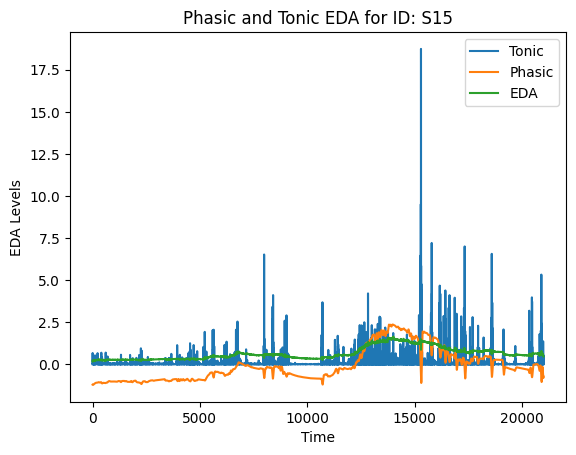

     pcost       dcost       gap    pres   dres
 0: -1.1256e+04 -1.1234e+04  3e+04  2e+02  3e-01
 1: -1.1240e+04 -1.2866e+04  2e+03  1e+01  2e-02
 2: -1.1238e+04 -1.1495e+04  3e+02  1e+00  3e-03
 3: -1.1238e+04 -1.1314e+04  8e+01  3e-01  6e-04
 4: -1.1244e+04 -1.1264e+04  2e+01  3e-02  7e-05
 5: -1.1255e+04 -1.1260e+04  6e+00  8e-03  2e-05
 6: -1.1258e+04 -1.1260e+04  2e+00  2e-03  4e-06
 7: -1.1259e+04 -1.1260e+04  8e-01  6e-04  1e-06
 8: -1.1259e+04 -1.1260e+04  3e-01  1e-04  2e-07
 9: -1.1260e+04 -1.1260e+04  1e-01  2e-05  5e-08
10: -1.1260e+04 -1.1260e+04  3e-02  1e-06  3e-09
11: -1.1260e+04 -1.1260e+04  9e-03  3e-07  6e-10
12: -1.1260e+04 -1.1260e+04  3e-03  5e-08  1e-10
13: -1.1260e+04 -1.1260e+04  6e-04  4e-09  8e-12
14: -1.1260e+04 -1.1260e+04  2e-04  6e-10  1e-12
15: -1.1260e+04 -1.1260e+04  2e-05  3e-11  7e-14
16: -1.1260e+04 -1.1260e+04  4e-06  4e-12  1e-14
Optimal solution found.


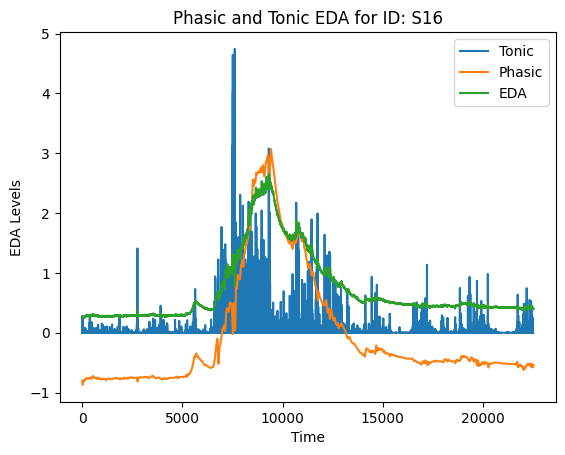

     pcost       dcost       gap    pres   dres
 0: -1.1703e+04 -1.1621e+04  5e+04  2e+02  2e-01
 1: -1.1718e+04 -2.1481e+04  1e+04  5e+01  4e-02
 2: -1.1742e+04 -1.5529e+04  4e+03  1e+01  9e-03
 3: -1.1753e+04 -1.3279e+04  2e+03  4e+00  3e-03
 4: -1.1755e+04 -1.3072e+04  1e+03  3e+00  3e-03
 5: -1.1761e+04 -1.2350e+04  6e+02  1e+00  1e-03
 6: -1.1761e+04 -1.2087e+04  3e+02  6e-01  5e-04
 7: -1.1765e+04 -1.1912e+04  1e+02  2e-01  2e-04
 8: -1.1779e+04 -1.1816e+04  4e+01  2e-02  2e-05
 9: -1.1794e+04 -1.1808e+04  1e+01  7e-03  6e-06
10: -1.1800e+04 -1.1806e+04  6e+00  1e-03  1e-06
11: -1.1803e+04 -1.1805e+04  2e+00  3e-04  2e-07
12: -1.1804e+04 -1.1805e+04  1e+00  7e-05  6e-08
13: -1.1804e+04 -1.1805e+04  3e-01  2e-05  1e-08
14: -1.1805e+04 -1.1805e+04  1e-01  5e-06  4e-09
15: -1.1805e+04 -1.1805e+04  4e-02  1e-06  9e-10
16: -1.1805e+04 -1.1805e+04  1e-02  1e-07  1e-10
17: -1.1805e+04 -1.1805e+04  3e-03  3e-08  2e-11
18: -1.1805e+04 -1.1805e+04  5e-04  3e-09  3e-12
19: -1.1805e+04 -1.18

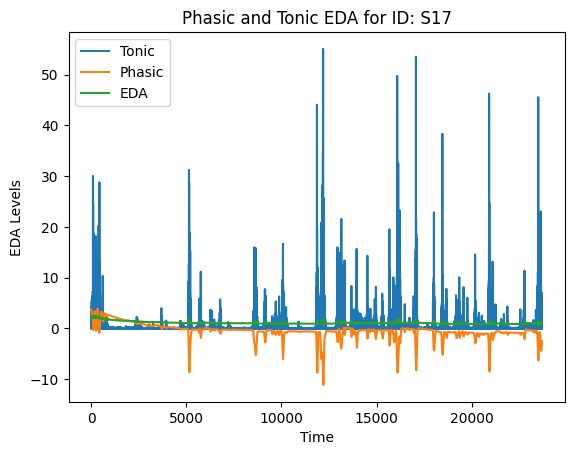

In [370]:
import matplotlib.pyplot as plt

# Define unique_ids
unique_ids = dataset['ID'].unique()

# Iterate through each unique id
for unique_id in unique_ids:
    # Filter data for each id
    subset_data = dataset[dataset['ID'] == unique_id]
    
    # Calculate EDA levels
    tonic, phasic = calculate_eda_levels(subset_data['w_eda'].values)
    
    # Plotting
    plt.plot(tonic, label='Tonic')
    plt.plot(phasic, label='Phasic')
    plt.plot(subset_data['w_eda'].values, label='EDA')
    
    plt.xlabel('Time')
    plt.ylabel('EDA Levels')
    plt.title(f'Phasic and Tonic EDA for ID: {unique_id}')
    plt.legend()
    plt.show()


In [9]:
print("Before replacing labels")
unique_labels_before = sequences_df['downsampled_label'].unique()
print(unique_labels_before, "\n")
print("Number of unique labels before replacement:", len(unique_labels_before), "\n")


Before replacing labels
[0. 1. 2. 4. 3.] 

Number of unique labels before replacement: 5 



In [10]:
sequences_df['downsampled_label'] = sequences_df['downsampled_label'].apply(lambda x : 1 if x == 2.0 else 0)


In [11]:
from sklearn import preprocessing

print("After replacing labels")
unique_labels_after = sequences_df['downsampled_label'].unique()
print(unique_labels_after)
print("Number of unique labels after replacement:", len(unique_labels_after))

le = preprocessing.LabelEncoder()  # Generates a look-up table
le.fit(sequences_df['downsampled_label'])
sequences_df['downsampled_label'] = le.transform(sequences_df['downsampled_label'])


After replacing labels
[0 1]
Number of unique labels after replacement: 2


In [12]:
num_classes = len(sequences_df['downsampled_label'].unique())
print(num_classes)


2


In [15]:
from collections import Counter

def plot_label_distribution(df):
    # Define class labels
    sorts = {
        0: "No-stress",
        1: "Stress"
    }

    # Count occurrences of each label
    label_counts = Counter(df['downsampled_label'])

    # Extract counts for '0' and '1'
    counts = [label_counts[0], label_counts[1]]
    print("Label distribution:", counts)

    # Define bar labels
    bar_labels = [sorts[0], sorts[1]]

    # Plotting
    plt.bar(bar_labels, counts)
    plt.title("Number of samples per class")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

Label distribution: [2408, 312]


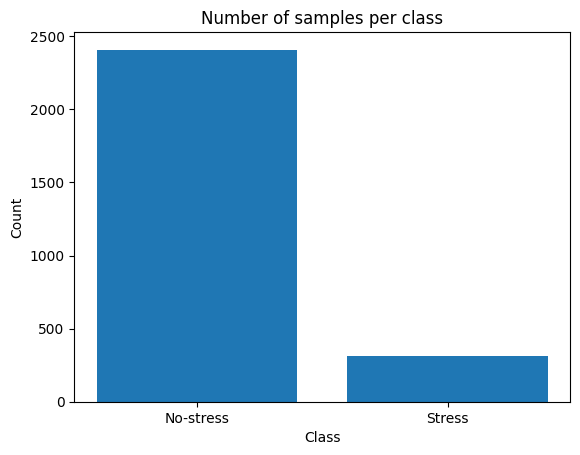

In [16]:
plot_label_distribution(sequences_df)


In [17]:
import pandas as pd
from sklearn.utils import resample

# Separate the majority ('no-stress') and minority ('stress') classes
df_no_stress = sequences_df[sequences_df['downsampled_label'] == 0]
df_stress = sequences_df[sequences_df['downsampled_label'] == 1]

# Downsample the majority class ('no-stress') to match the minority class ('stress')
df_no_stress_downsampled = resample(df_no_stress,
                                    replace=False,  # Sample without replacement
                                    n_samples=len(df_stress),  # Match the number of 'stress' samples
                                    random_state=42)  # Ensure reproducibility

# Combine the downsampled 'no-stress' class with the 'stress' class
sequences_df_balanced = pd.concat([df_no_stress_downsampled, df_stress])

# Shuffle the combined dataset to mix the samples
sequences_df_balanced = sequences_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Now sequences_df_balanced contains a balanced dataset with 'no-stress' samples evenly undersampled to match 'stress' samples

Label distribution: [312, 312]


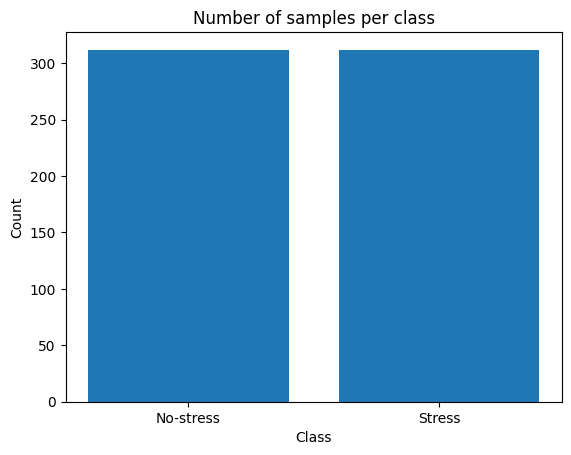

In [18]:
plot_label_distribution(sequences_df_balanced)

****Scale and split data****

We perform a simple Min-Max scaling to bring the value-range between 0 and 1. We do not use Standard Scaling as the data does not follow a Gaussian distribution.

In [19]:
# Scale the 'w_eda' feature
scaler = preprocessing.MinMaxScaler()
eda_series_list_scaled = [scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in sequences_df_balanced["w_eda"]]

# Convert the scaled feature back to a list of arrays
eda_array_list = [np.array(series).flatten() for series in eda_series_list_scaled]

# Separate the labels
labels_list = [i for i in sequences_df_balanced['downsampled_label']]

# Convert the labels list to numpy array
labels_array = np.array(labels_list)

# print(len(combined_series_list))
print(f"EDA list Count:", len(eda_series_list_scaled),"\n" "Labels list Count:", len(labels_array))



EDA list Count: 624 
Labels list Count: 624


In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Padding sequences to ensure uniform length
max_sequence_length = 128  # Choose the desired maximum sequence length
padded_series_list = pad_sequences(eda_series_list_scaled, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')

# Splitting data into training and testing sets (70% train, 30% test)
x_temp, x_test, y_temp, y_test = model_selection.train_test_split(
    padded_series_list, labels_list, test_size=0.30, random_state=42, shuffle=True
)

# Further splitting the training data into training and validation sets (80% train, 20% val from the original 70% train)
x_train, x_val, y_train, y_val = model_selection.train_test_split(
    x_temp, y_temp, test_size=0.20, random_state=42, shuffle=True
)

# Convert to numpy arrays and reshape for compatibility with Keras
x_train = np.asarray(x_train).astype(np.float32).reshape(-1, max_sequence_length, 1)  # Assuming 1 feature (EDA or TEMP)
y_train = np.asarray(y_train).astype(np.float32).reshape(-1, 1)
y_train = keras.utils.to_categorical(y_train)

x_val = np.asarray(x_val).astype(np.float32).reshape(-1, max_sequence_length, 1)  # Assuming 1 feature (EDA or TEMP)
y_val = np.asarray(y_val).astype(np.float32).reshape(-1, 1)
y_val = keras.utils.to_categorical(y_val)

x_test = np.asarray(x_test).astype(np.float32).reshape(-1, max_sequence_length, 1)  # Assuming 1 feature (EDA or TEMP)
y_test = np.asarray(y_test).astype(np.float32).reshape(-1, 1)
y_test = keras.utils.to_categorical(y_test)

# Check lengths of train, validation, and test sets
print(
    f"Length of x_train : {len(x_train)}\nLength of x_val : {len(x_val)}\nLength of x_test : {len(x_test)}\n"
    f"Length of y_train : {len(y_train)}\nLength of y_val : {len(y_val)}\nLength of y_test : {len(y_test)}"
)

Length of x_train : 348
Length of x_val : 88
Length of x_test : 188
Length of y_train : 348
Length of y_val : 88
Length of y_test : 188


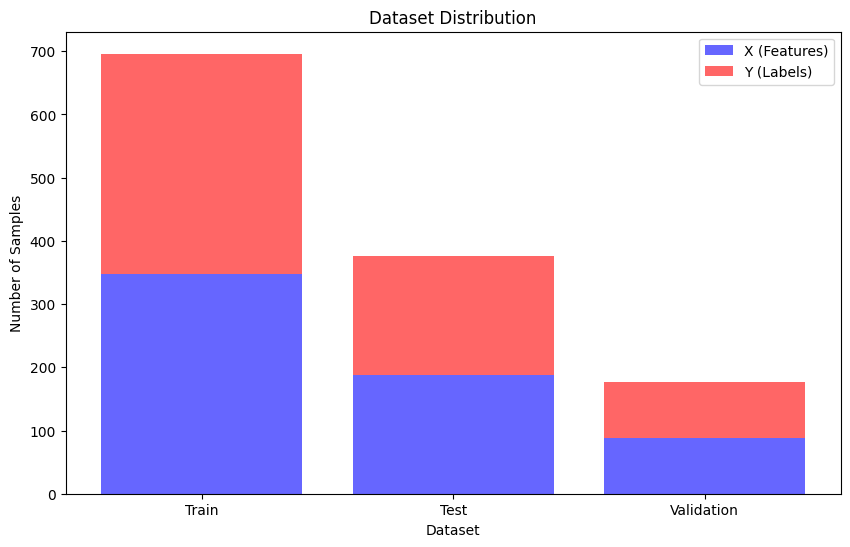

In [21]:
def plot_dataset_distribution(x_train, y_train, x_test, y_test, x_val, y_val):
    """
    Plots a bar chart showing the sizes of the train, validation, and test sets.

    Parameters:
    - x_train, y_train: Training data and labels.
    - x_val, y_val: Validation data and labels.
    - x_test, y_test: Test data and labels.
    """
    dataset_names = ['Train', 'Test', 'Validation']
    x_lengths = [len(x_train), len(x_test), len(x_val)]
    y_lengths = [len(y_train), len(y_test), len(y_val)]
    
    # Plotting the bar plot
    plt.figure(figsize=(10, 6))
    
    plt.bar(dataset_names, x_lengths, color='b', alpha=0.6, label='X (Features)')
    plt.bar(dataset_names, y_lengths, color='r', alpha=0.6, label='Y (Labels)', bottom=x_lengths)
    
    plt.xlabel('Dataset')
    plt.ylabel('Number of Samples')
    plt.title('Dataset Distribution')
    plt.legend()
    plt.show()


# Plot dataset distribution
plot_dataset_distribution(x_train, y_train, x_test, y_test, x_val, y_val)

In [22]:
# Creating tf.data.Datasets from numpy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Shuffling and batching the datasets
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


In [23]:
vals_dict = {}
for i in sequences_df_balanced['downsampled_label']:
    if i in vals_dict.keys():
        vals_dict[i] += 1
    else:
        vals_dict[i] = 1
total = sum(vals_dict.values())

# Formula used - Naive method where
# weight = 1 - (no. of samples present / total no. of samples)
# So more the samples, lower the weight

weight_dict = {k: (1 - (v / total)) for k, v in vals_dict.items()}
print(weight_dict)



{1: 0.5, 0: 0.5}


In [24]:
# Assuming your one-hot encoded labels are in a variable named 'labels'
binary_labels = np.argmax(sequences_df_balanced['downsampled_label'])
print("Shape of binary labels:", binary_labels.shape)

Shape of binary labels: ()


In [25]:
def plot_history_metrics(history: keras.callbacks.History):
    total_plots = len(history.history)
    cols = total_plots // 2

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()

In [28]:
from tensorflow import keras
from tensorflow.keras import layers

def create_model():
    input_layer = keras.Input(shape=(128, 1))

    x = layers.Conv1D(
        filters=32, kernel_size=3, strides=2, activation="relu", padding="same"
    )(input_layer)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=64, kernel_size=3, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=128, kernel_size=5, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=256, kernel_size=5, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=512, kernel_size=7, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=1024,
        kernel_size=7,
        strides=2,
        activation="relu",
        padding="same",
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(2048, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Dense(128, activation="relu")(x)

    output_layer = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=input_layer, outputs=output_layer)
    
    return model


In [29]:
conv_model = create_model()
conv_model.summary()

# Save model to JSON
# Done for Kevin Bevers for his Headless CMS Stress platform prototype project
model_json = conv_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 64, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 32, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 16, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 8, 256)         │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 4, 512)         │       918,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 2, 1024)        │     3,671,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2, 1024)        │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       131,20

 Total params: 23,821,505 (90.87 MB)

 Trainable params: 23,817,473 (90.86 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [32]:
epochs = 100

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"  # Change monitor to "val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",  # Change monitor to "val_loss"
        factor=0.2,
        patience=2,
        min_lr=0.000001,
    ),
]

optimizer = keras.optimizers.Adam(amsgrad=True, learning_rate=0.001)
loss = keras.losses.BinaryCrossentropy()

In [33]:
conv_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[
        keras.metrics.BinaryAccuracy(),  # Use BinaryAccuracy instead of TopKCategoricalAccuracy for binary classification
        keras.metrics.AUC(),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
    ],
)

conv_model_history = conv_model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_dataset,
    class_weight=weight_dict,
)


Epoch 1/100


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 2), output.shape=(None, 1)

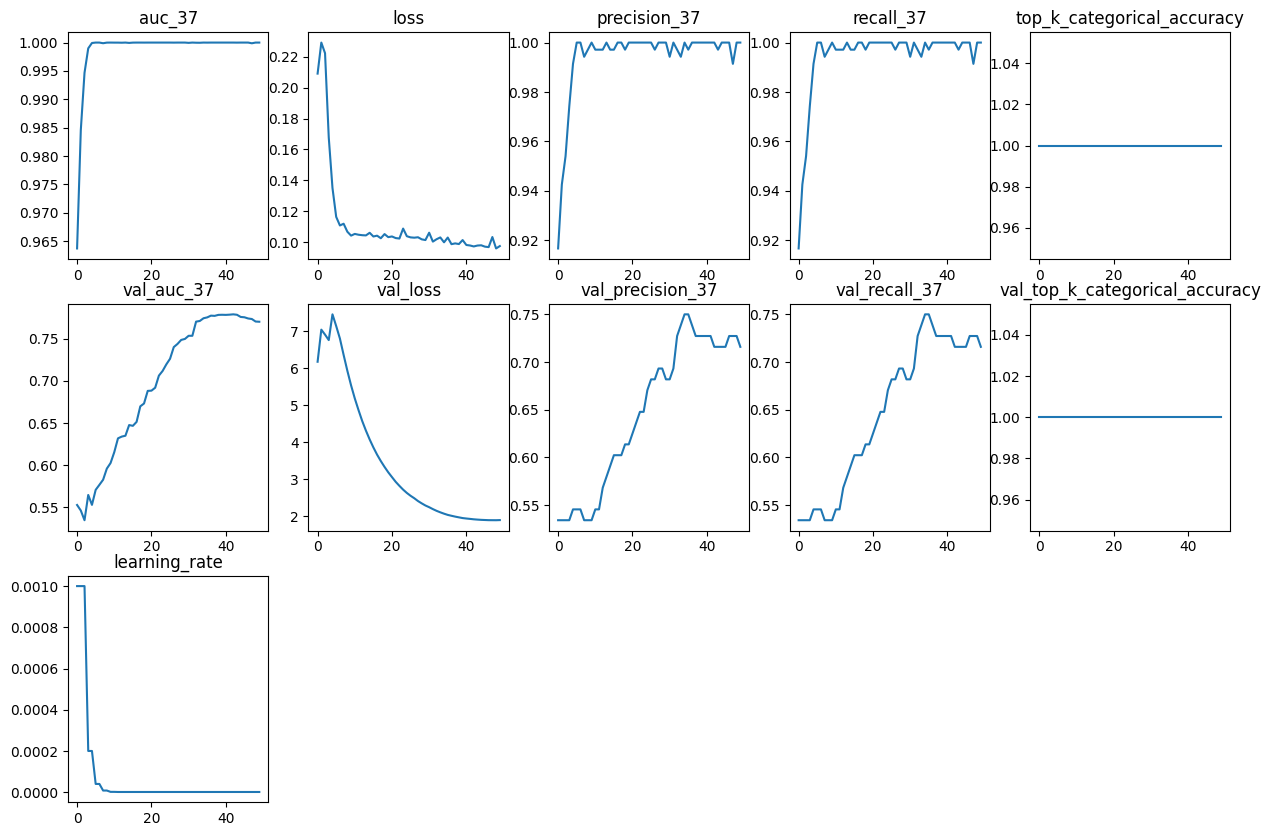

In [469]:
plot_history_metrics(conv_model_history)

Plotting signals with label 0:


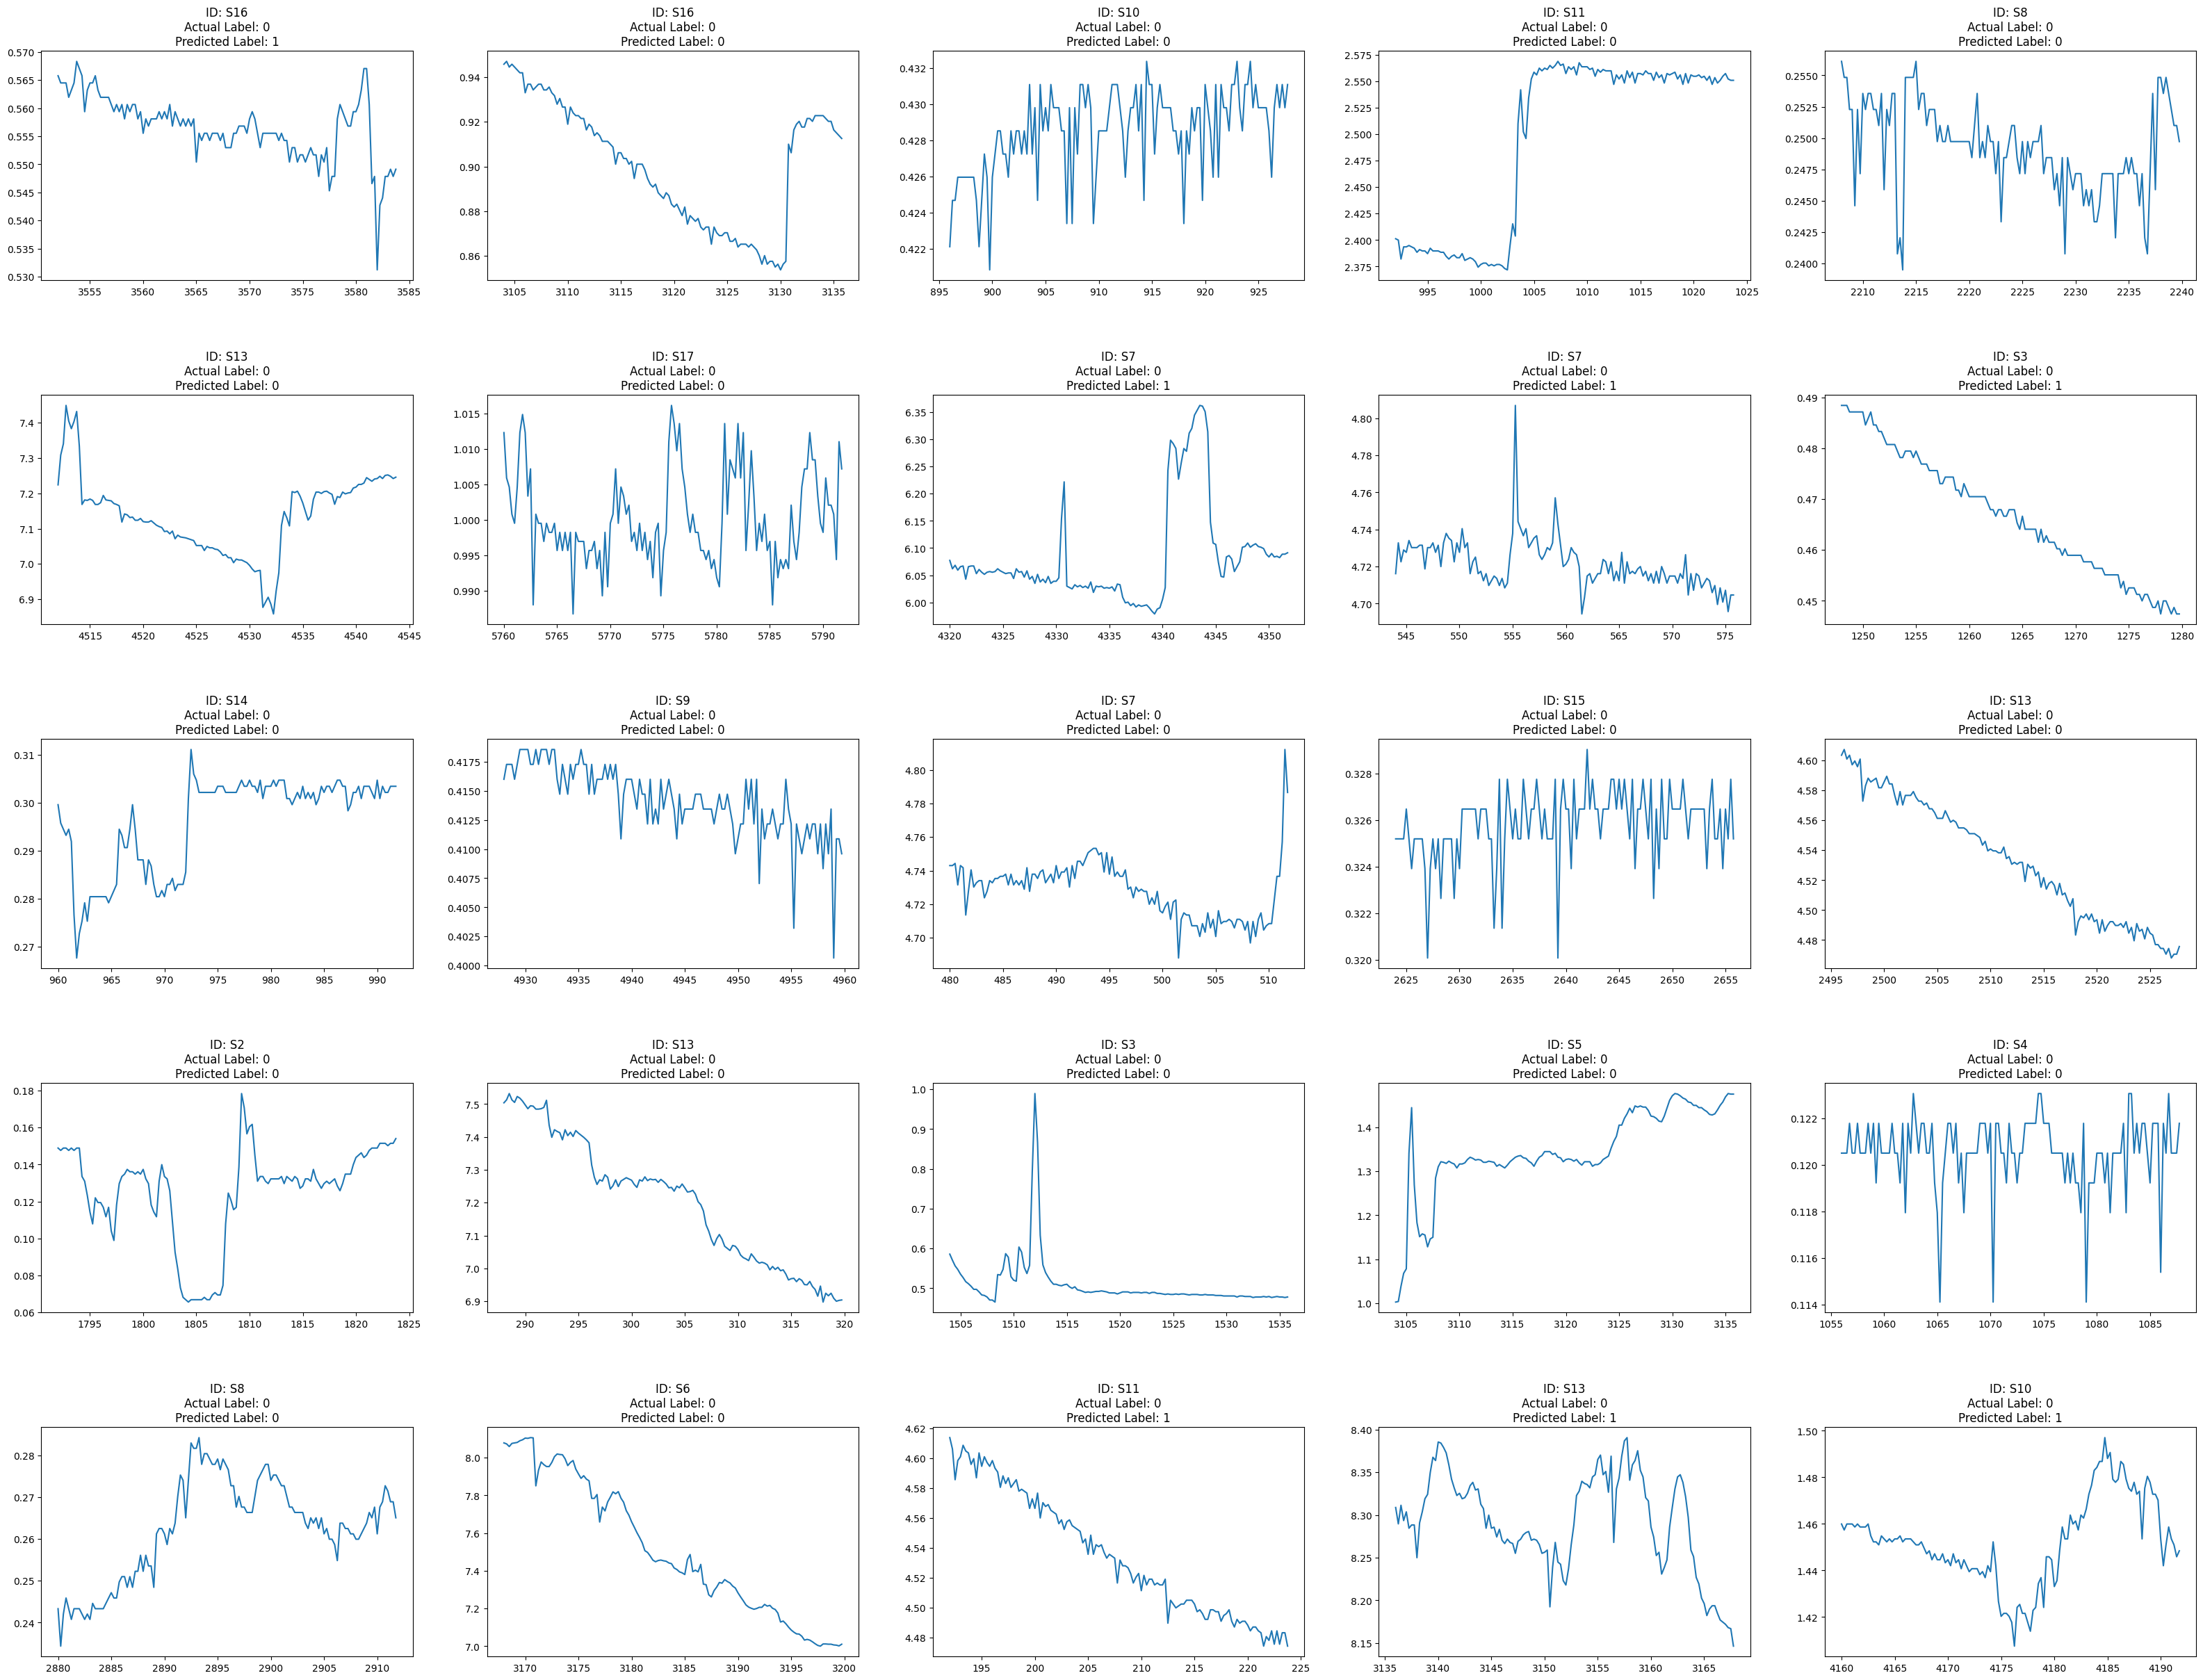

Plotting signals with label 1:


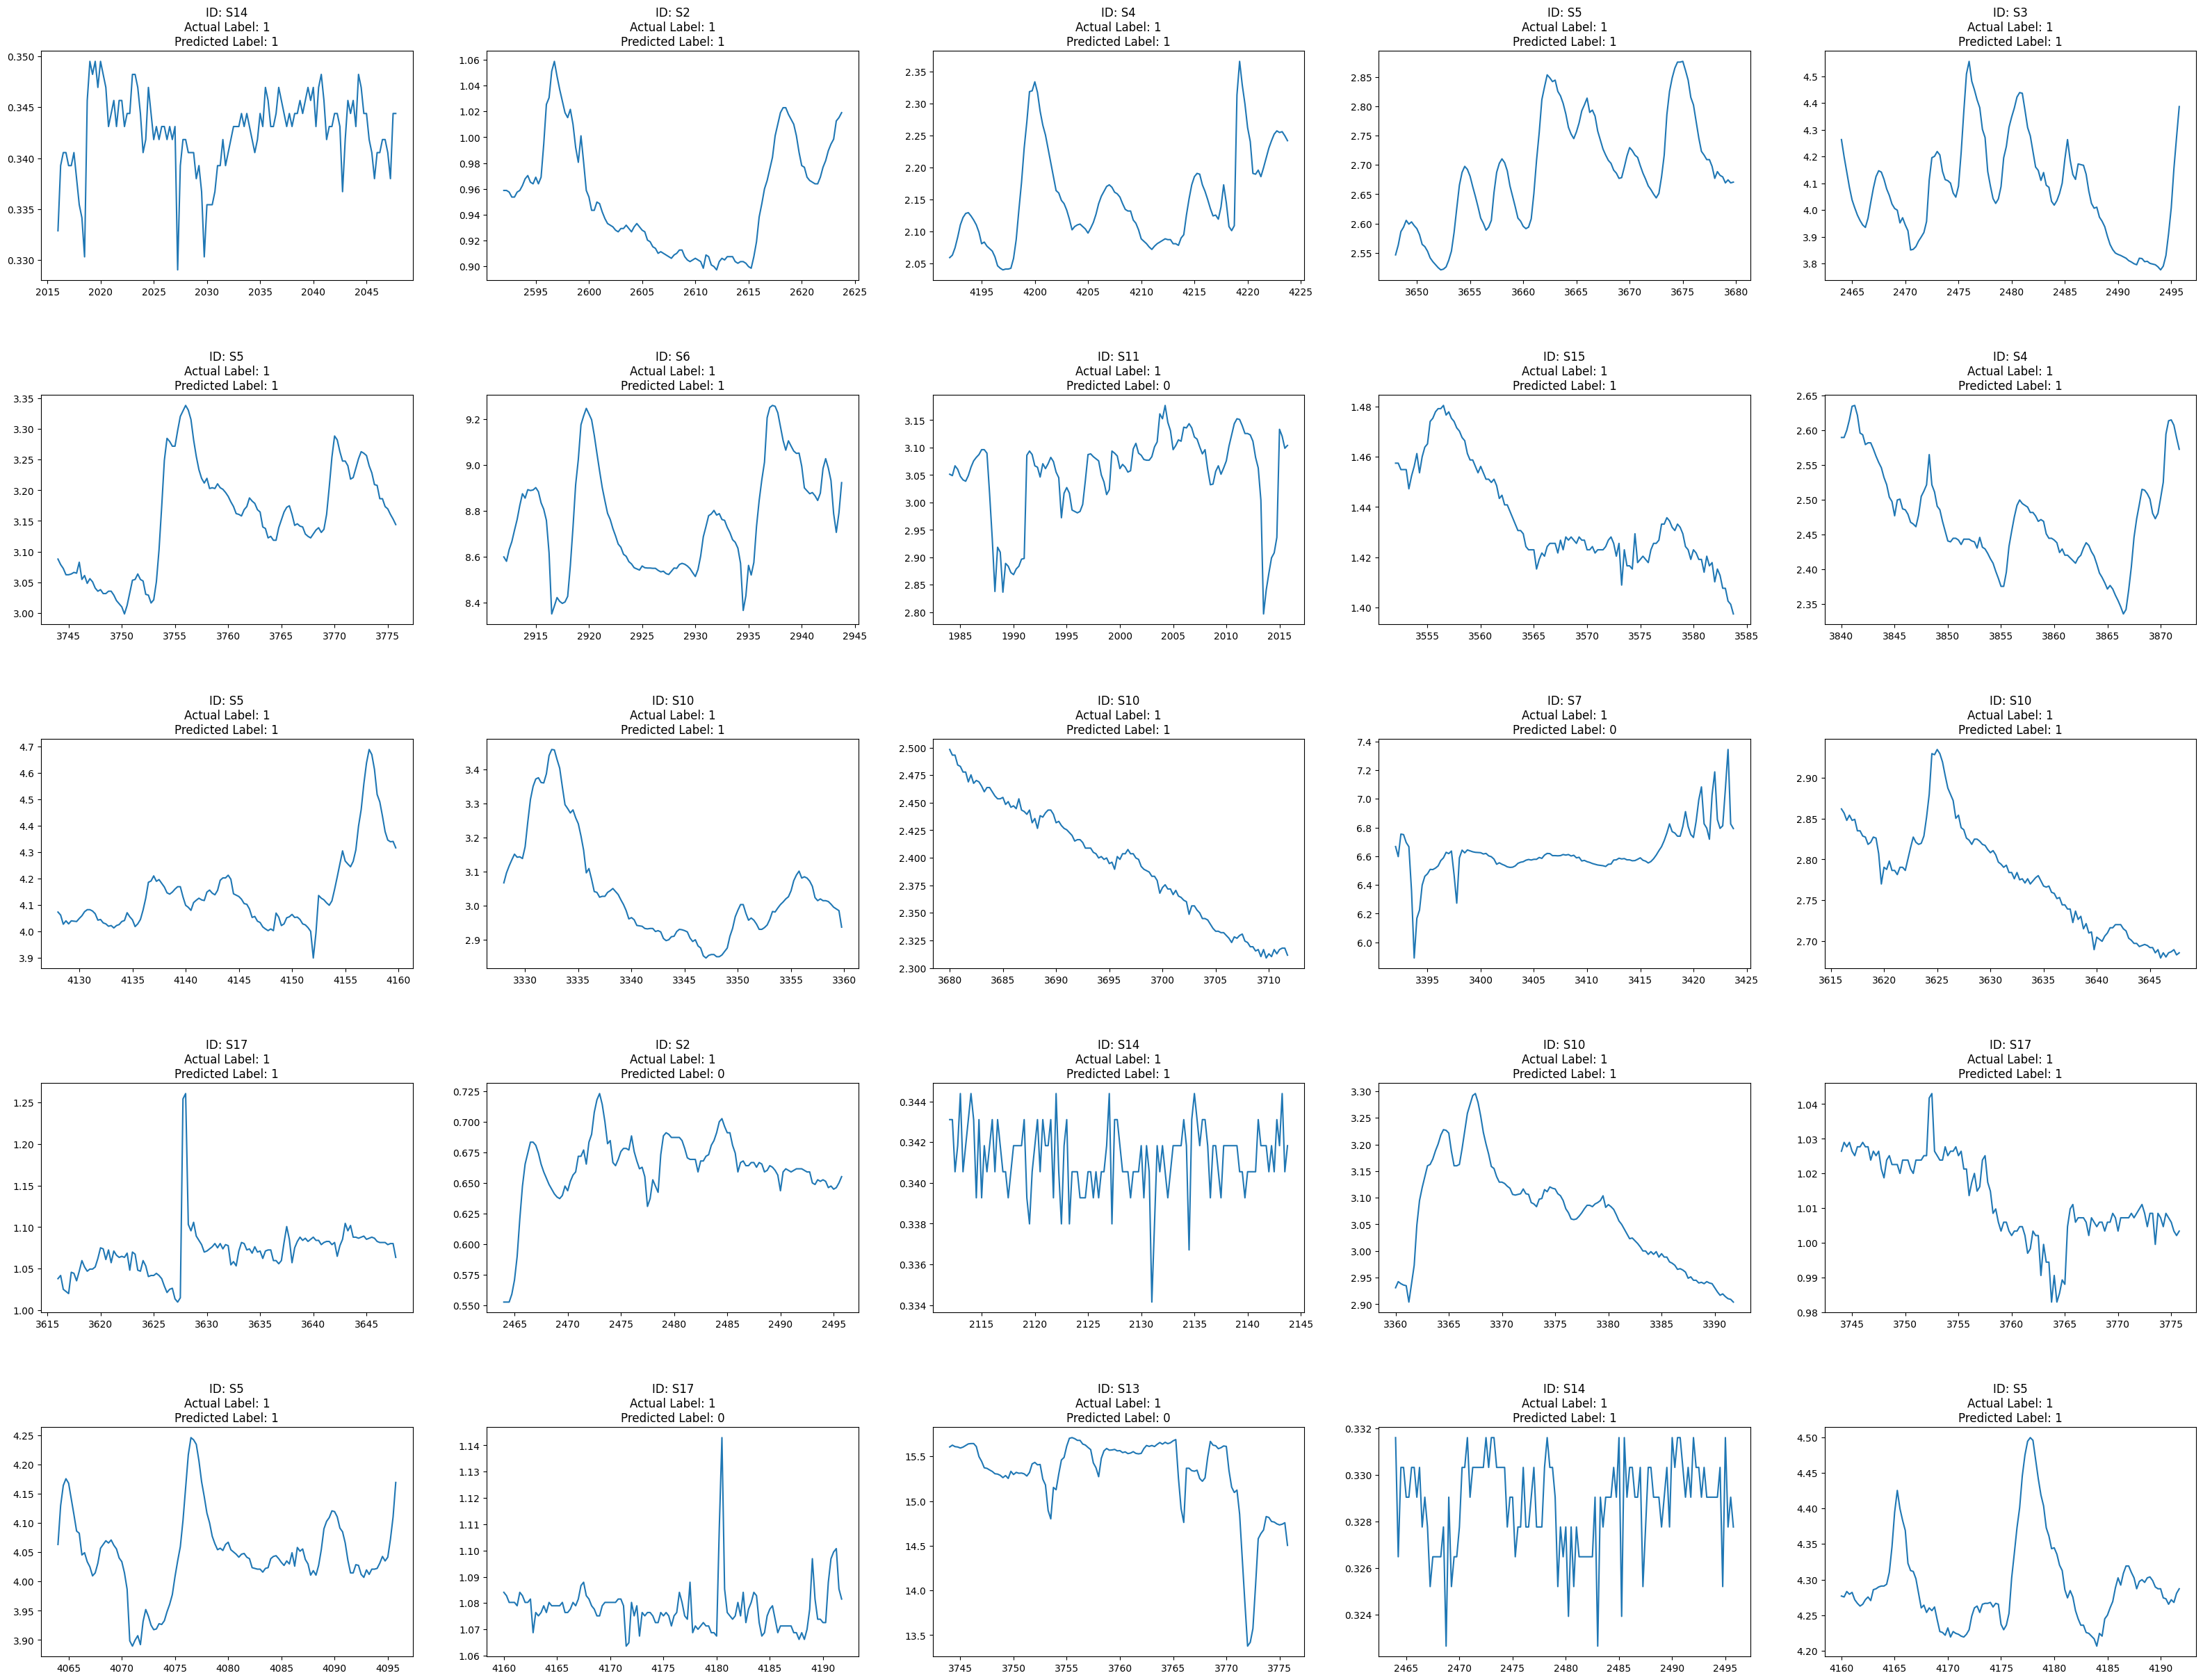

In [470]:
import numpy as np
import matplotlib.pyplot as plt

def view_evaluated_eeg_plots(model, sequences_df, scaler):
    # Function to plot a subset of EEG signals with their actual and predicted labels
    def plot_signals(data, labels, predictions, ids, times):
        total_plots = len(data)
        cols = total_plots // 5
        rows = total_plots // cols
        if total_plots % cols != 0:
            rows += 1
        pos = range(1, total_plots + 1)
        fig = plt.figure(figsize=(40, 30))
        for i, (plot_data, og_label, pred_label, id_, time) in enumerate(zip(data, labels, predictions, ids, times)):
            plt.subplot(rows, cols, pos[i])
            plt.plot(time, plot_data)
            plt.title(f"ID: {id_}\nActual Label: {og_label}\nPredicted Label: {pred_label}")
            fig.subplots_adjust(hspace=0.5)
        plt.show()

    # Generate two sets of 25 signals each for labels 0 and 1
    def generate_signals_for_label(label, num_signals=25):
        filtered_df = sequences_df[sequences_df['downsampled_label'] == label]
        sampled_df = filtered_df.sample(n=num_signals, random_state=42)
        data = sampled_df['w_eda']
        times = sampled_df['Time']
        data_array = [scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in data]
        data_array = np.asarray(data_array).astype(np.float32).reshape(-1, 128, 1)
        labels = sampled_df['downsampled_label'].tolist()
        ids = sampled_df['ID'].tolist()  # Extract IDs
        predictions = np.argmax(model.predict(data_array, verbose=0), axis=1)
        return data, labels, predictions, ids, times

    data_0, labels_0, predictions_0, ids_0, times_0 = generate_signals_for_label(0)
    data_1, labels_1, predictions_1, ids_1, times_1 = generate_signals_for_label(1)
    
    print("Plotting signals with label 0:")
    plot_signals(data_0, labels_0, predictions_0, ids_0, times_0)
    
    print("Plotting signals with label 1:")
    plot_signals(data_1, labels_1, predictions_1, ids_1, times_1)

# Call the function with the required arguments
view_evaluated_eeg_plots(conv_model, sequences_df, scaler)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - auc_37: 0.6784 - loss: 2.9408 - precision_37: 0.6208 - recall_37: 0.6208 - top_k_categorical_accuracy: 1.0000
Loss : 2.975261688232422
Top 3 Categorical Accuracy : 0.6522748470306396
Area under the Curve (ROC) : 0.6010638475418091
Precision : 0.6010638475418091
Recall : 1.0


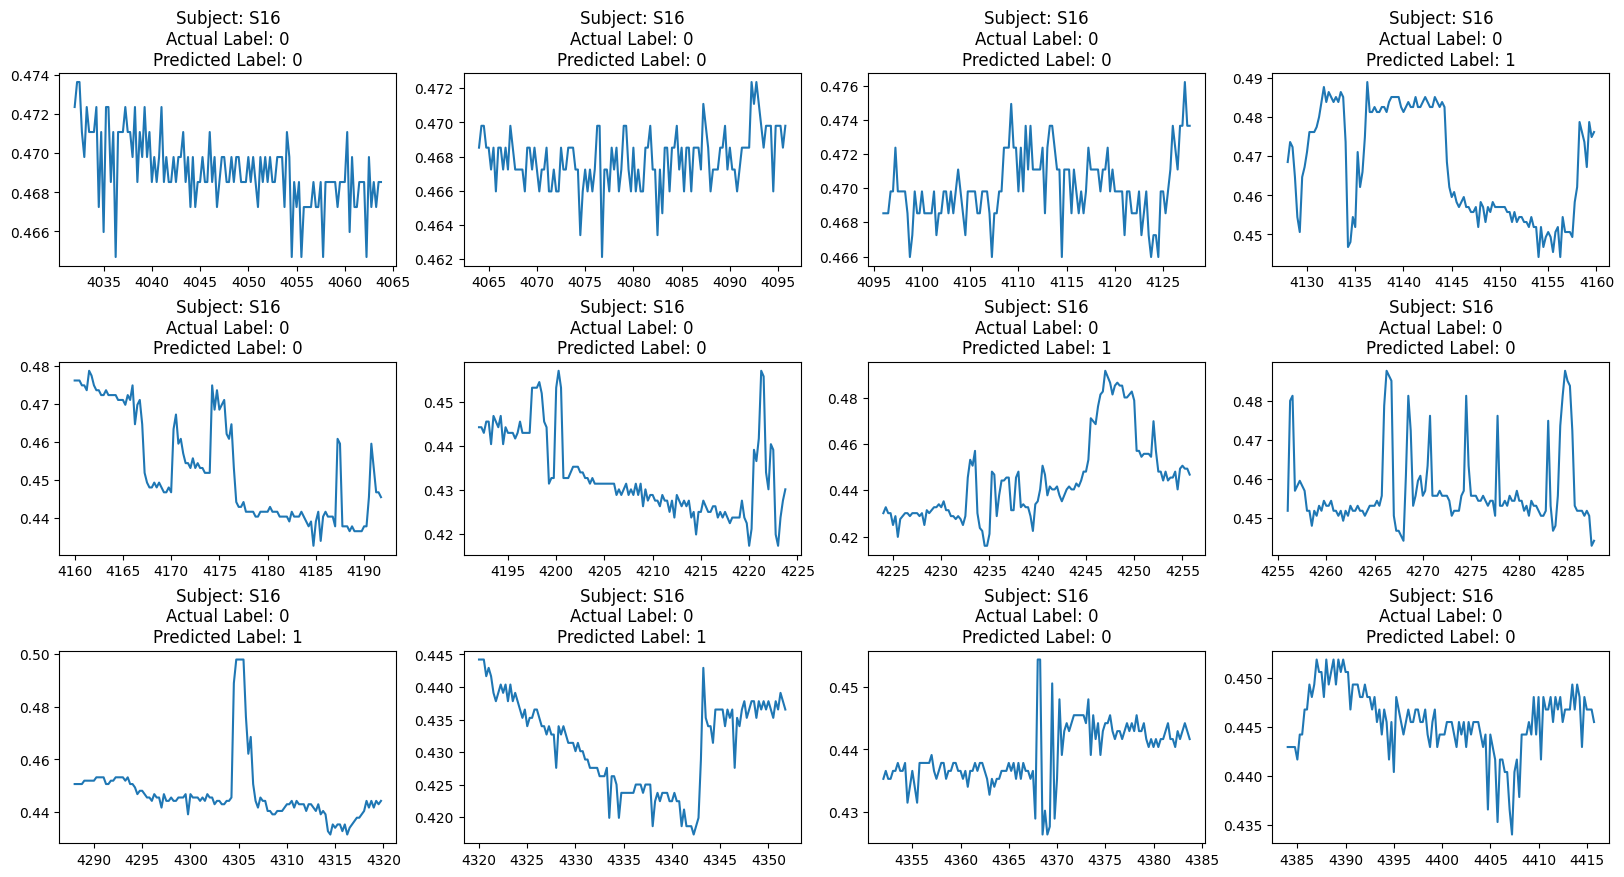

In [471]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Assuming sequences_df, scaler, and conv_model are already defined

# Evaluate the model and print evaluation metrics
loss, accuracy, auc, precision, recall = conv_model.evaluate(test_dataset)
print(f"Loss : {loss}")
print(f"Top 3 Categorical Accuracy : {accuracy}")
print(f"Area under the Curve (ROC) : {auc}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")

def view_evaluated_eeg_plots(model):
    start_index = random.randint(10, len(sequences_df) - 12)
    end_index = start_index + 11
    data = sequences_df.loc[start_index:end_index, 'w_eda']
    time = sequences_df.loc[start_index:end_index, 'Time']
    subjects = sequences_df.loc[start_index:end_index, 'ID']

    # Ensure the time series data and time are aligned correctly
    data_array = [scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in data]
    data_array = np.asarray(data_array).astype(np.float32).reshape(-1, 128, 1)
    
    original_labels = sequences_df.loc[start_index:end_index, 'downsampled_label']
    predicted_labels = np.argmax(model.predict(data_array, verbose=0), axis=1)

    total_plots = len(data)
    cols = total_plots // 3
    rows = total_plots // cols
    if total_plots % cols != 0:
        rows += 1
    pos = range(1, total_plots + 1)
    
    fig = plt.figure(figsize=(20, 10))
    for i, (plot_data, og_label, pred_label, subject) in enumerate(zip(data, original_labels, predicted_labels, subjects)):
        plt.subplot(rows, cols, pos[i])
        plt.plot(time.iloc[i], plot_data)
        plt.title(f"Subject: {subject}\nActual Label: {og_label}\nPredicted Label: {pred_label}")
        fig.subplots_adjust(hspace=0.5)
    
    plt.show()

view_evaluated_eeg_plots(conv_model)
